In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping

In [9]:
logger = LoggerCallback(update_step=50)
early_stopping = EarlyStopping(patience=50)

In [10]:
for i in range(0,5):
    print(f"Location: {i:20} Revision {i:1}")

Location:                    0 Revision 0
Location:                    1 Revision 1
Location:                    2 Revision 2
Location:                    3 Revision 3
Location:                    4 Revision 4


In [11]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=[logger, early_stopping]
)

In [12]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(X_val, y_val, dtype_X='float', dtype_y='float')

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=32)
val_loader = DataLoader(val_wrapper, batch_size=32)

In [13]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=1000)

INFO:root:Starting training process on cpu


INFO:root:Epoch 0/            1000 | Train loss: 8433.490211123511 | Validation loss: 8433.490211123511 | Time/epoch:          0.02817 seconds
INFO:root:Epoch 1/            1000 | Train loss: 8429.580636160714 | Validation loss: 8429.580636160714 | Time/epoch:          0.02742 seconds
INFO:root:Epoch 50/            1000 | Train loss: 8241.995698474702 | Validation loss: 8241.995698474702 | Time/epoch:          0.01869 seconds
INFO:root:Epoch 100/            1000 | Train loss: 8054.2007068452385 | Validation loss: 8054.2007068452385 | Time/epoch:          0.01752 seconds
INFO:root:Epoch 150/            1000 | Train loss: 7869.563034784226 | Validation loss: 7869.563034784226 | Time/epoch:          0.01621 seconds
INFO:root:Epoch 200/            1000 | Train loss: 7687.8012927827385 | Validation loss: 7687.8012927827385 | Time/epoch:          0.01805 seconds
INFO:root:Epoch 250/            1000 | Train loss: 7508.732328869048 | Validation loss: 7508.732328869048 | Time/epoch:          0.

In [14]:
from torchfitter.conventions import ParamsDict

In [15]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

In [16]:
python, java, p_num, j_num = ["Python Users", "Java Users", 8.2, 7.5]
print(f"|{python:16}|{java:16}|\n|{p_num:16}|{j_num:16}|")

|Python Users    |Java Users      |
|             8.2|             7.5|


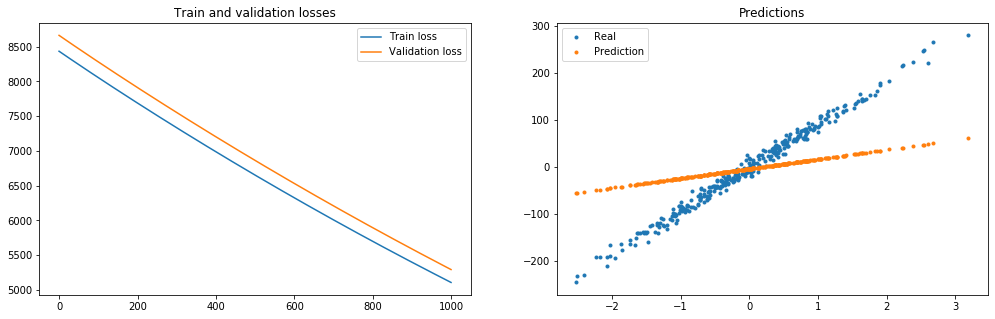

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

ax[0].plot(trainer.params_dict['history']['train_loss'], label='Train loss')
ax[0].plot(trainer.params_dict['history']['validation_loss'], label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();